pip install hvplot

import sys
sys.path.append('/kaggle/working/mysitepackages')

## Importing the libraries

In [1]:
import numpy as np 
import pandas as pd
#import hvplot.pandas
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing, model_selection, metrics
from xgboost import XGBClassifier
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/loan-defaulter/application_data.csv
/kaggle/input/loan-defaulter/previous_application.csv
/kaggle/input/loan-defaulter/columns_description.csv


In [2]:
application_df = pd.read_csv("/kaggle/input/loan-defaulter/application_data.csv")
prev_application_df = pd.read_csv("/kaggle/input/loan-defaulter/previous_application.csv")
col_description_df = pd.read_csv("/kaggle/input/loan-defaulter/columns_description.csv")

In [3]:
col_description_df.shape

(160, 5)

In [4]:
col_description_df.loc[col_description_df.Table=='application_data',['Row','Description']]

,Row,Description
0,SK_ID_CURR,ID of loan in our sample
1,TARGET,Target variable (1 - client with payment diffi...
2,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving
3,CODE_GENDER,Gender of the client
4,FLAG_OWN_CAR,Flag if the client owns a car
...,...,...
117,AMT_REQ_CREDIT_BUREAU_DAY,Number of enquiries to Credit Bureau about the...
118,AMT_REQ_CREDIT_BUREAU_WEEK,Number of enquiries to Credit Bureau about the...
119,AMT_REQ_CREDIT_BUREAU_MON,Number of enquiries to Credit Bureau about the...
120,AMT_REQ_CREDIT_BUREAU_QRT,Number of enquiries to Credit Bureau about the...


## Understanding the data ##

In [5]:
X = application_df.drop(['SK_ID_CURR','TARGET'],axis=1)
Y = application_df.TARGET

In [6]:
X.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 120 entries, NAME_CONTRACT_TYPE to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(39), object(16)
memory usage: 281.5+ MB


In [8]:
X.describe()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,-4986.120328,-2994.202373,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,3522.886321,1509.450419,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,-24672.000000,-7197.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,-7479.500000,-4299.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,-4504.000000,-3254.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,-2010.000000,-1720.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


In [9]:
#application_df['TARGET'].value_counts().hvplot.bar(title="Loan Defaulter Counts",xlabel="Loan Defaulter", width = 250, height = 300)

### Performing preprocessing. This involves three steps: 
    1) Handling missing values
    2) Encoding categorical data
    3) Scaling 
    

#### Step 1 - Handling missing values ####

In [10]:
missing_data = X.isnull().sum().sort_values(ascending=False)
missing_data = missing_data[missing_data>0]

print(f"Total features with missing values: {len(missing_data)}")

Total features with missing values: 67


In [11]:
missing_percentage = (100.0*missing_data/application_df.shape[0])

In [12]:
missing_percentage[:30].index

Index(['COMMONAREA_MODE', 'COMMONAREA_MEDI', 'COMMONAREA_AVG',
       'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAPARTMENTS_AVG',
       'NONLIVINGAPARTMENTS_MODE', 'FONDKAPREMONT_MODE',
       'LIVINGAPARTMENTS_AVG', 'LIVINGAPARTMENTS_MODE',
       'LIVINGAPARTMENTS_MEDI', 'FLOORSMIN_AVG', 'FLOORSMIN_MEDI',
       'FLOORSMIN_MODE', 'YEARS_BUILD_MODE', 'YEARS_BUILD_AVG',
       'YEARS_BUILD_MEDI', 'OWN_CAR_AGE', 'LANDAREA_MEDI', 'LANDAREA_MODE',
       'LANDAREA_AVG', 'BASEMENTAREA_MEDI', 'BASEMENTAREA_MODE',
       'BASEMENTAREA_AVG', 'EXT_SOURCE_1', 'NONLIVINGAREA_MODE',
       'NONLIVINGAREA_AVG', 'NONLIVINGAREA_MEDI', 'ELEVATORS_AVG',
       'ELEVATORS_MODE', 'ELEVATORS_MEDI'],
      dtype='object')

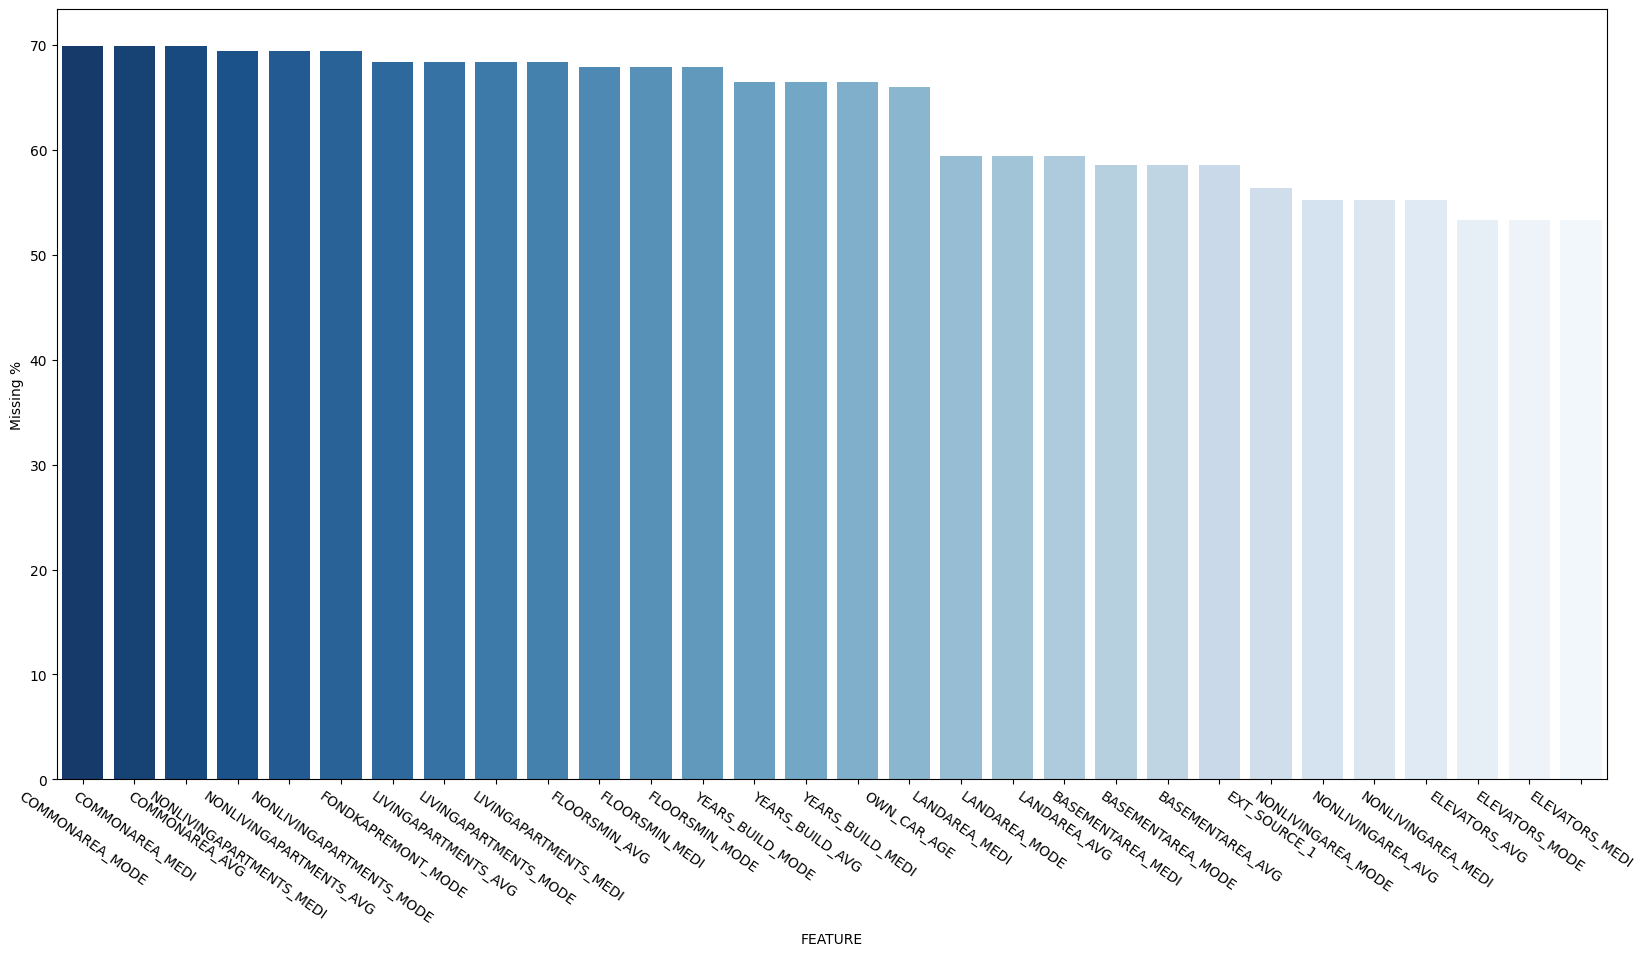

In [13]:
plt.figure(figsize=(20,10))
sns.barplot(x = missing_percentage.index[:30], y = missing_percentage.values[:30],palette='Blues_r')
plt.xticks(rotation=325)
plt.xlabel("FEATURE",fontsize = 10)
plt.ylabel("Missing %",fontsize = 10)
plt.show()

In [14]:
missing_percentage[31:].index

Index(['APARTMENTS_MODE', 'APARTMENTS_MEDI', 'APARTMENTS_AVG',
       'ENTRANCES_MEDI', 'ENTRANCES_MODE', 'ENTRANCES_AVG', 'LIVINGAREA_MEDI',
       'LIVINGAREA_MODE', 'LIVINGAREA_AVG', 'HOUSETYPE_MODE', 'FLOORSMAX_MEDI',
       'FLOORSMAX_AVG', 'FLOORSMAX_MODE', 'YEARS_BEGINEXPLUATATION_MEDI',
       'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BEGINEXPLUATATION_MODE',
       'TOTALAREA_MODE', 'EMERGENCYSTATE_MODE', 'OCCUPATION_TYPE',
       'EXT_SOURCE_3', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'NAME_TYPE_SUITE',
       'DEF_60_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
       'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_30_CNT_SOCIAL_CIRCLE', 'EXT_SOURCE_2',
       'AMT_GOODS_PRICE', 'AMT_ANNUITY', 'CNT_FAM_MEMBERS',
       'DAYS_LAST_PHONE_CHANGE'],
      dtype='object')

#### For most of the features with missing data, such as apartment size, common area, living area etc, the mean, median, and mode have been provided. Instead of using all three of them, only features with the median can be retained.

In [15]:
X = X.drop([col for col in X.columns if 'AVG' in col or 'MODE' in col],axis=1)

In [16]:
missing_data = X.isnull().sum().sort_values(ascending=False)
missing_data = missing_data[missing_data>0]

print(f"Total features with missing values: {len(missing_data)}")
missing_percentage = (100.0*missing_data/application_df.shape[0])

Total features with missing values: 34


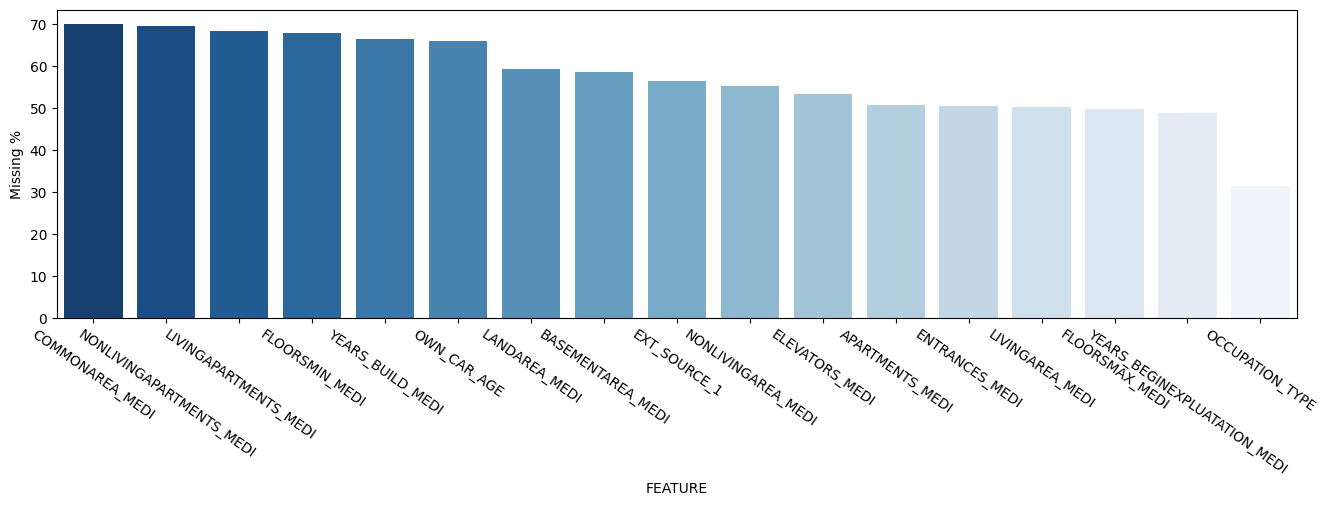

In [17]:
plt.figure(figsize=(16,4))
sns.barplot(x = missing_percentage.index[:17], y = missing_percentage.values[:17],palette='Blues_r')
plt.xticks(rotation=325)
plt.xlabel("FEATURE",fontsize = 10)
plt.ylabel("Missing %",fontsize = 10)
plt.show()

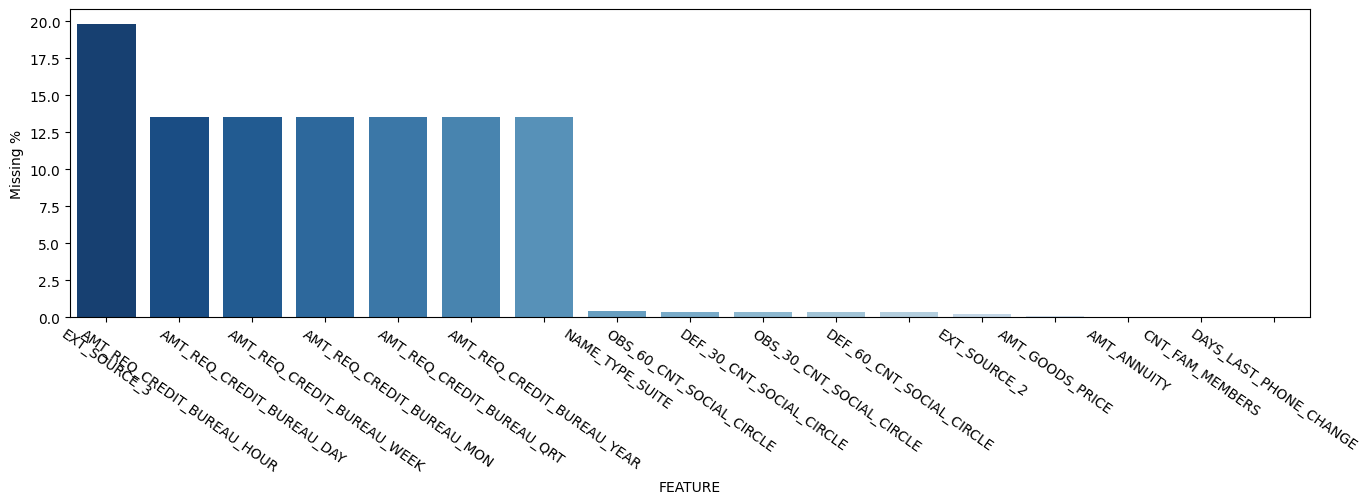

In [18]:
plt.figure(figsize=(16,4))
sns.barplot(x = missing_percentage.index[17:], y = missing_percentage.values[17:],palette='Blues_r')
plt.xticks(rotation=325)
plt.xlabel("FEATURE",fontsize = 10)
plt.ylabel("Missing %",fontsize = 10)
plt.show()

<p> Many of the missing values are related to the housing details of the employee. This could be due to <b>two factors:</b><br>
    <ol>
        <li> The data was not collected.</li>
        <li> The data was not available. For example, If there are no elevators in a property, then it could be blank.</li>
    </ol>
    Either ways, if more than 60% of the data is missing, then those features will be dropped.
</p>

##### **Starting with 'OWN_CAR_AGE' feature** #####

In [19]:
own_car_missing = X.loc[X['OWN_CAR_AGE'].isna()==True,['FLAG_OWN_CAR','OWN_CAR_AGE']]

In [20]:
own_car_missing.value_counts('FLAG_OWN_CAR')

FLAG_OWN_CAR
N    202924
Y         5
Name: count, dtype: int64

In [21]:
own_car_missing_index = X.loc[(X.FLAG_OWN_CAR=='Y') & (X.OWN_CAR_AGE.isna()==True)].index

##### **For those records where FLAG_OWN_CAR = N, OWN_CAR_AGE can be set to -1, as individuals do not own a car. For the 5 other records where data is missing, they can be removed.**

In [22]:
X.drop(own_car_missing_index,inplace=True)

In [23]:
X.shape

(307506, 87)

In [24]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='constant',fill_value = -1)

In [25]:
imputer.fit(np.reshape(X['OWN_CAR_AGE'],(-1,1)))

SimpleImputer(fill_value=-1, strategy='constant')

In [26]:
X['OWN_CAR_AGE'] = imputer.transform(np.reshape(X['OWN_CAR_AGE'],(-1,1)))

Inspecting <b>'NAME_HOUSING_TYPE'</b> and <b>'FLAG_OWN_REALTY'</b> to understand why data is missing.

In [27]:
cols_to_be_dropped = ['COMMONAREA_MEDI','NONLIVINGAPARTMENTS_MEDI','NONLIVINGAREA_MEDI',
                      'LIVINGAPARTMENTS_MEDI','LIVINGAREA_MEDI','FLOORSMIN_MEDI','FLOORSMAX_MEDI',
                      'YEARS_BUILD_MEDI','YEARS_BEGINEXPLUATATION_MEDI','BASEMENTAREA_MEDI','ELEVATORS_MEDI',
                      'APARTMENTS_MEDI','ENTRANCES_MEDI','LANDAREA_MEDI']

In [28]:
housing_types = X.NAME_HOUSING_TYPE.unique()

In [29]:
X.groupby(['FLAG_OWN_REALTY','NAME_HOUSING_TYPE'])[['NAME_HOUSING_TYPE']].count()

NAME_HOUSING_TYPE
FLAG_OWN_REALTY NAME_HOUSING_TYPE                     
N               Co-op apartment                    424
                House / apartment                73668
                Municipal apartment               6822
                Office apartment                  1224
                Rented apartment                  2795
                With parents                      9263
Y               Co-op apartment                    698
                House / apartment               199195
                Municipal apartment               4361
                Office apartment                  1393
                Rented apartment                  2086
                With parents                      5577

In [30]:
housing_missing_data = X[X[cols_to_be_dropped].isna().any(axis=1)][['NAME_HOUSING_TYPE','FLAG_OWN_REALTY','REGION_RATING_CLIENT_W_CITY']]

In [31]:
housing_missing_data.value_counts()

NAME_HOUSING_TYPE    FLAG_OWN_REALTY  REGION_RATING_CLIENT_W_CITY
House / apartment    Y                2                              111656
                     N                2                               42017
                     Y                3                               21513
                                      1                               12301
                     N                3                                8263
With parents         N                2                                5413
House / apartment    N                1                                4517
With parents         Y                2                                3264
Municipal apartment  N                2                                2860
Rented apartment     N                2                                1807
Municipal apartment  Y                2                                1661
With parents         N                3                                1309
Rented apartment     Y

In [32]:
X.groupby(['FLAG_OWN_REALTY','NAME_HOUSING_TYPE'])[['BASEMENTAREA_MEDI']].mean()

BASEMENTAREA_MEDI
FLAG_OWN_REALTY NAME_HOUSING_TYPE                     
N               Co-op apartment               0.077274
                House / apartment             0.087748
                Municipal apartment           0.078365
                Office apartment              0.075884
                Rented apartment              0.081581
                With parents                  0.089019
Y               Co-op apartment               0.089105
                House / apartment             0.088740
                Municipal apartment           0.082006
                Office apartment              0.080644
                Rented apartment              0.081103
                With parents                  0.089947

In [33]:
for housing_type in housing_types:
    housing_info = X.loc[X.NAME_HOUSING_TYPE==housing_type,cols_to_be_dropped]
    print(f'Housing Type: {housing_type}\nTotal records: {housing_info.shape[0]}\nMissing values per type:\n{housing_info.isnull().sum()}\n')

Housing Type: House / apartment
Total records: 272863
Missing values per type:
COMMONAREA_MEDI                 190487
NONLIVINGAPARTMENTS_MEDI        189381
NONLIVINGAREA_MEDI              150332
LIVINGAPARTMENTS_MEDI           186452
LIVINGAREA_MEDI                 136929
FLOORSMIN_MEDI                  185090
FLOORSMAX_MEDI                  135726
YEARS_BUILD_MEDI                181381
YEARS_BEGINEXPLUATATION_MEDI    133067
BASEMENTAREA_MEDI               159435
ELEVATORS_MEDI                  145110
APARTMENTS_MEDI                 138351
ENTRANCES_MEDI                  137284
LANDAREA_MEDI                   161908
dtype: int64

Housing Type: Rented apartment
Total records: 4881
Missing values per type:
COMMONAREA_MEDI                 3932
NONLIVINGAPARTMENTS_MEDI        3904
NONLIVINGAREA_MEDI              3395
LIVINGAPARTMENTS_MEDI           3881
LIVINGAREA_MEDI                 3210
FLOORSMIN_MEDI                  3865
FLOORSMAX_MEDI                  3204
YEARS_BUILD_MEDI          

In [34]:
X = X.drop(cols_to_be_dropped,axis=1) 

#### For the columns, EXT_SOURCE_1 and EXT_SOURCE_3, the missing values will be filled by -1

In [35]:
X.fillna(value = {'OCCUPATION_TYPE':'Missing', 'EXT_SOURCE_1':0,'EXT_SOURCE_3':0},inplace=True)

In [36]:
X.isnull().sum().sort_values(ascending=False)

AMT_REQ_CREDIT_BUREAU_YEAR     41519
AMT_REQ_CREDIT_BUREAU_QRT      41519
AMT_REQ_CREDIT_BUREAU_MON      41519
AMT_REQ_CREDIT_BUREAU_WEEK     41519
AMT_REQ_CREDIT_BUREAU_DAY      41519
                               ...  
REG_REGION_NOT_WORK_REGION         0
LIVE_REGION_NOT_WORK_REGION        0
REG_CITY_NOT_LIVE_CITY             0
CODE_GENDER                        0
REG_CITY_NOT_WORK_CITY             0
Length: 73, dtype: int64

In [37]:
amt_cols = [col for col in X.columns if 'AMT_REQ_CREDIT' in col]
vals = [-1]*len(amt_cols)

In [38]:
X.fillna(value={amt_col:val for amt_col,val in zip(amt_cols,vals)},inplace=True)

In [39]:
X = X.dropna()

<p><b>Checkpoint 1 - Missing data processing summary:</b><br>
    <ol>
        <li>Dropping features - 14 features were dropped, as nearly 50-70% percent of the data was missing for each of them.</li>
        <li>Imputing data - For categorical data, a new category called 'Missing' was imputed, whereas for the numerical features, either -1 or 1 was used for filling the missing data.</li>
        <li>Dropping rows - For those features with roughly 2% missing data, only those rows with missing values was deleted.</li>
    </ol>
    <br>
    Proceeding to the next section, categorical data encoding. 
</p>